In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import shap
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, BorderlineSMOTE

In [146]:
np.random.seed(42)

In [147]:
data = pd.read_csv('../data/processed/data.csv')
X = data[[column for column in list(data.columns) 
          if column not in ['label', 'session_id', 'new_label','entropy',
                            'acceleration_pos_neg_ratio','acceleration_std',
                            'clicks_count', 'durations','hover_frequency','speed_cv']]]
y = data[['new_label']]


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)


In [149]:
feature_names = [column for column in list(data.columns) 
          if column not in ['label', 'session_id', 'new_label','entropy',
                            'acceleration_pos_neg_ratio','acceleration_std',
                            'clicks_count', 'durations','hover_frequency','speed_cv']]

#### 1. Model Ensemble: Voting Classifier

In [150]:
# DEFINE BEST DECISION TREE PIPELINE (ADASYN) 
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [151]:
# Train on full training set
tree_pipe_adasyn.fit(X_train, y_train)

Pipeline(steps=[('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [152]:
# -DEFINE BEST KNN PIPELINE (Borderline-SMOTE) 

best_k = 5  

knn_pipe_borderline = Pipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

In [153]:
# Train on full training set
knn_pipe_borderline.fit(X_train, y_train)

/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('borderline_smote',
                 BorderlineSMOTE(random_state=42,
                                 sampling_strategy='minority')),
                ('knn', KNeighborsClassifier())])

In [154]:
#  BUILD FINAL VOTING ENSEMBLE 
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree_adasyn', tree_pipe_adasyn),
        ('knn_borderline', knn_pipe_borderline)
    ],
    voting='soft'  # Soft voting to use predicted probabilities
)

In [155]:
# Train ensemble
ensemble_model.fit(X_train, y_train)


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('decision_tree_adasyn',
                              Pipeline(steps=[('adasyn',
                                               ADASYN(random_state=42,
                                                      sampling_strategy='minority')),
                                              ('tree',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      random_state=42))])),
                             ('knn_borderline',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('borderline_smote',
                                               BorderlineSMOTE(random_state=42,
                                                               sampling_strategy='minority')),
                                              ('knn',
                                               KNeighborsClassifier())]))],
                 voting='soft')

In [156]:
# PREDICT AND EVALUATE ENSEMBLE 
y_pred_ensemble = ensemble_model.predict(X_test)
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')
ensemble_roc_auc = roc_auc_score(y_test, y_prob_ensemble)

print(f"Voting Test Accuracy: {ensemble_accuracy:.4f}")
print(f"Voting F1-Score (Weighted): {ensemble_f1:.4f}")
print(f"Voting ROC AUC: {ensemble_roc_auc:.4f}")


Voting Test Accuracy: 0.9833
Voting F1-Score (Weighted): 0.9831
Voting ROC AUC: 0.9997


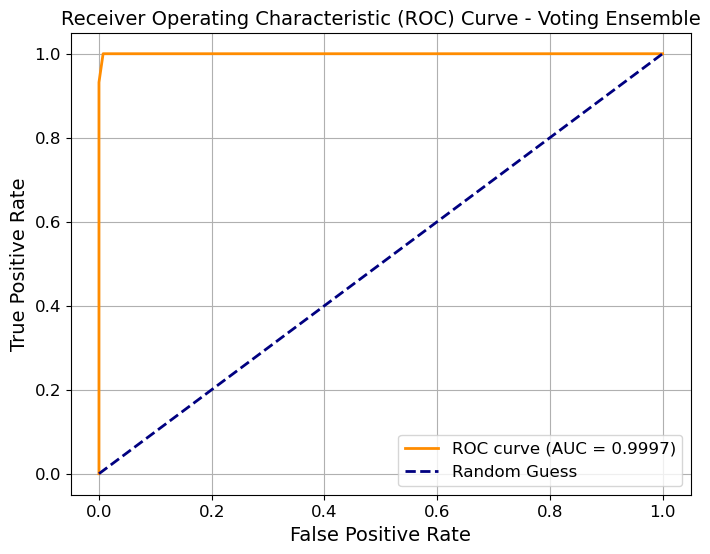

In [157]:

roc_auc = roc_auc_score(y_test, y_prob_ensemble)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ensemble, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Voting Ensemble', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

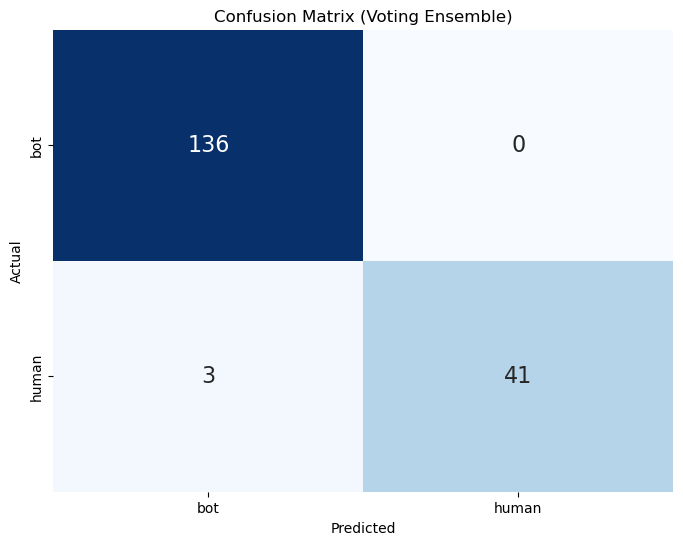

In [158]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Voting Ensemble)')
plt.show()

#### 2. Stacking Method & SHAP (SHapley Additive exPlanations)

This increases explanability of the model.

Train each model type separately, then use a meta-model to make predictions.

In [159]:

# Best k value for KNN
best_k = 5

# Pipelines with resampling
# Decision Tree pipeline with ADASYN
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# KNN pipeline with BorderlineSMOTE
knn_pipe_borderline = Pipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

# Meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[
        ('decision_tree', tree_pipe_adasyn),
        ('knn', knn_pipe_borderline)
    ],
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba'
)

# Fit model
stacking_clf.fit(X_train, y_train)

# Predict
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:, 1]

# Get scores
stacking_accuracy = accuracy_score(y_test, y_pred)
stacking_f1 = f1_score(y_test, y_pred, average='weighted')
stacking_roc_auc = roc_auc_score(y_test, y_prob)

print(f"Stacking Test Accuracy: {stacking_accuracy:.4f}")
print(f"Stacking F1-Score (Weighted): {stacking_f1:.4f}")
print(f"Stacking ROC AUC: {stacking_roc_auc:.4f}")


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Stacking Test Accuracy: 0.9944
Stacking F1-Score (Weighted): 0.9944
Stacking ROC AUC: 0.9999


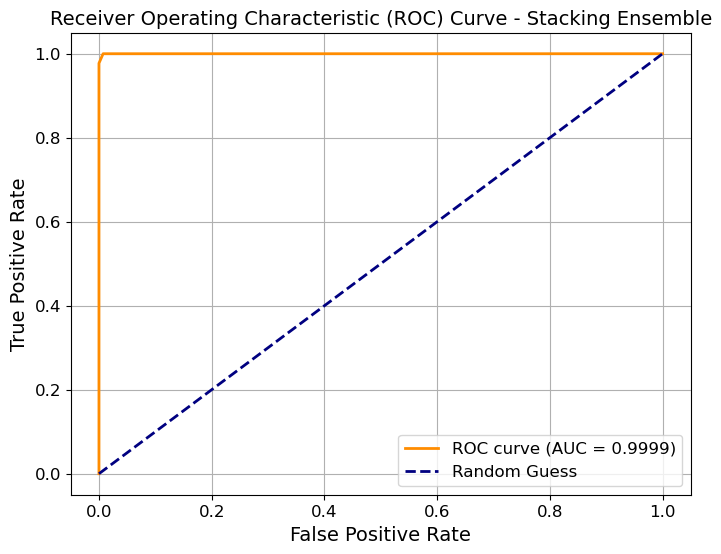

In [160]:

roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Stacking Ensemble', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

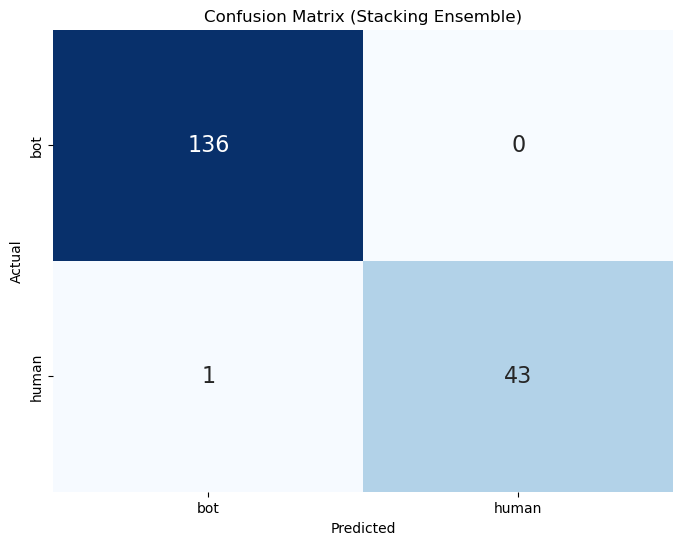

In [161]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stacking Ensemble)')
plt.show()

In [162]:
# --- Interpretability ---

# Fit base pipelines separately for interpretation
tree_pipe_adasyn.fit(X_train, y_train)
knn_pipe_borderline.fit(X_train, y_train)

# Decision Tree rules
print("\n--- Decision Tree Rules ---")
tree = tree_pipe_adasyn.named_steps['tree']
tree_rules = export_text(tree, feature_names=feature_names)
print(tree_rules)


--- Decision Tree Rules ---
|--- avg_hover_duration <= 3143.87
|   |--- idle_active_ratio <= 0.64
|   |   |--- avg_hover_duration <= 586.49
|   |   |   |--- class: bot
|   |   |--- avg_hover_duration >  586.49
|   |   |   |--- class: human
|   |--- idle_active_ratio >  0.64
|   |   |--- acceleration_mean <= -45.01
|   |   |   |--- direction_change_frequency <= 0.41
|   |   |   |   |--- class: bot
|   |   |   |--- direction_change_frequency >  0.41
|   |   |   |   |--- avg_hover_duration <= 735.54
|   |   |   |   |   |--- class: bot
|   |   |   |   |--- avg_hover_duration >  735.54
|   |   |   |   |   |--- class: human
|   |   |--- acceleration_mean >  -45.01
|   |   |   |--- class: bot
|--- avg_hover_duration >  3143.87
|   |--- direction_change_frequency <= 0.40
|   |   |--- class: bot
|   |--- direction_change_frequency >  0.40
|   |   |--- class: human



/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Show the 5 nearest neighbours for the first test sample

In [163]:
# KNN Nearest Neighbors for a sample
print("\n--- KNN Nearest Neighbors (for first test sample) ---")
knn = knn_pipe_borderline.named_steps['knn']

# Ensure that the input to kneighbors is 2D
distances, indices = knn.kneighbors(X_test.iloc[[0]].values.reshape(1, -1))  # Use iloc and pass as 2D


print("Distances:", distances)
print("Neighbor indices:", indices)
print("Neighbor labels:", y_train.iloc[knn._y[indices.flatten()]].values)



--- KNN Nearest Neighbors (for first test sample) ---
Distances: [[1200.86075965 1201.95948674 1202.39013139 1203.41791795 1203.74974041]]
Neighbor indices: [[ 61  76 286 261 267]]
Neighbor labels: [['human']
 ['human']
 ['human']
 ['human']
 ['human']]


In [164]:
# Logistic Regression coefficients (meta-model)
print("\n--- Meta-model (Logistic Regression) Coefficients ---")
meta_model.fit(X_train, y_train)
for name, coef in zip(feature_names, meta_model.coef_[0]):
    print(f"{name}: {coef:.3f}")


--- Meta-model (Logistic Regression) Coefficients ---
avg_hover_duration: 0.000
acceleration_mean: -0.001
acceleration_skewness: -0.001
direction_change_frequency: -0.200
idle_active_ratio: -0.000
click_frequency: -0.000
time_afternoon: -0.012
time_evening: -0.003
time_morning: 0.000
time_night: 0.000
time_wee_hours: 0.000


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### SHAP Values Calculation

We then make use of SHAP values to understand how each feature contributes to a particular prediction in the model ensemble.

In [165]:
# SHAP interpretation for the stacking model
print("\n--- SHAP Interpretation ---")
explainer = shap.Explainer(stacking_clf.predict_proba, X_train)
shap_values = explainer(X_test)


--- SHAP Interpretation ---


PermutationExplainer explainer: 181it [00:23,  4.23it/s]                         


Draw summary plot for bot class

/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_54937/3646233487.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[...,0], X_test, plot_size=(12, 8))


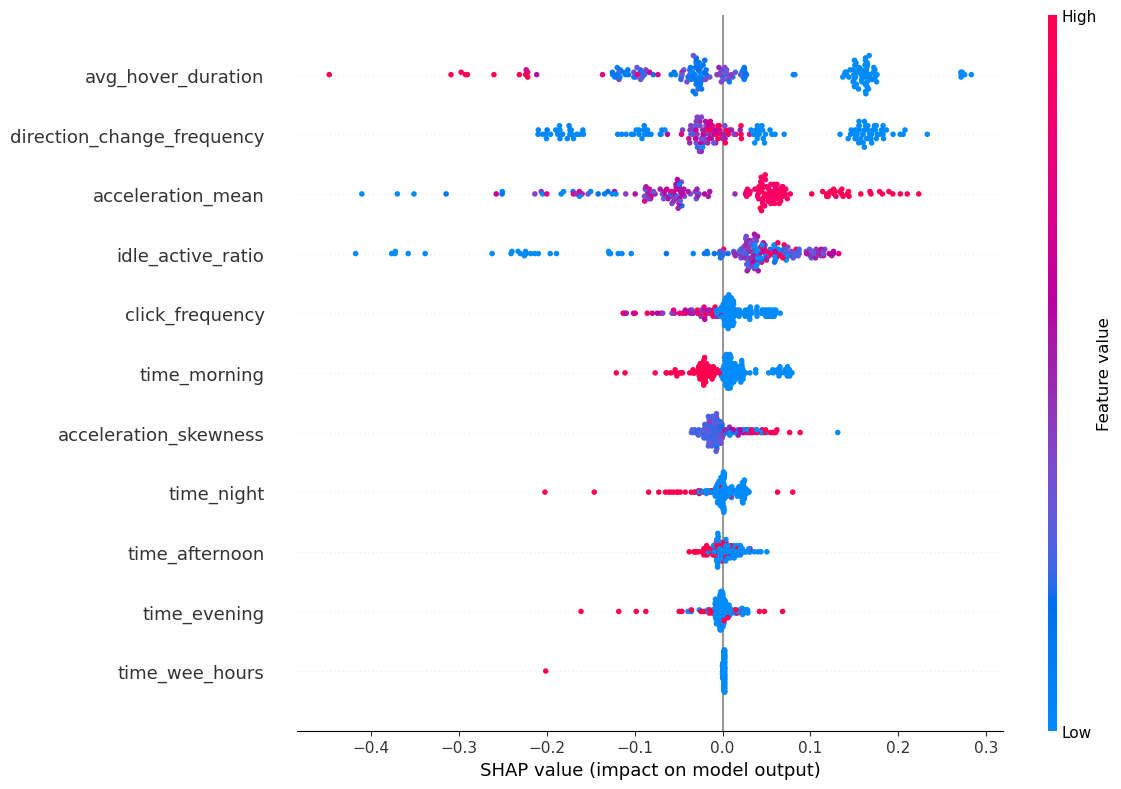

In [166]:

# Visualize SHAP summary plot
shap.initjs()
# Plot the SHAP summary plot with customized figure size and font size

shap.summary_plot(shap_values[...,0], X_test, plot_size=(12, 8))



Draw summary plot for human class

/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_54937/262139888.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[...,1], X_test, plot_size=(12, 8))


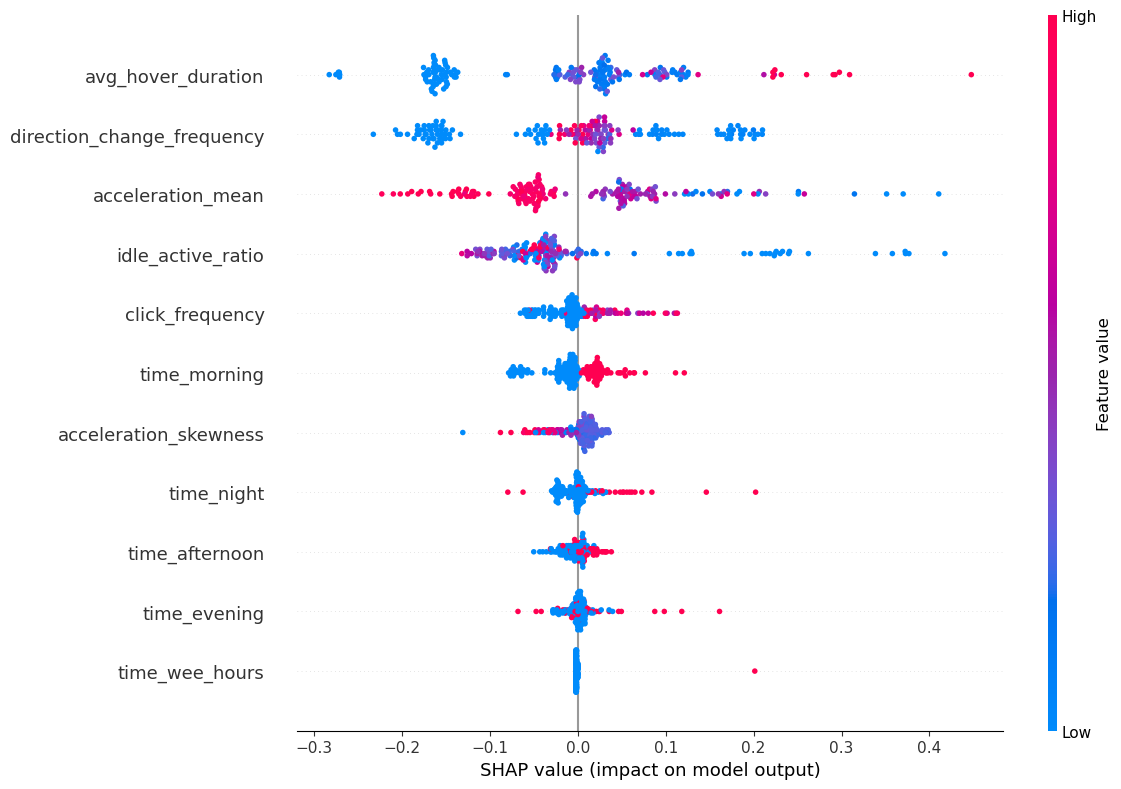

In [167]:
# Visualize SHAP summary plot
shap.initjs()
# Plot the SHAP summary plot with customized figure size and font size

shap.summary_plot(shap_values[...,1], X_test, plot_size=(12, 8))

##### SHAP values for one test session

The further left a bar is, the less indicative the feature is for the session to be human.

The further right a bar is, the more indicative the feature is for the session to be human.


Explanation:

E(f(x)): The baseline prediction across all data points in the training dataset, before any features are taken into account for for the particular session being predicted on.

f(x): the model's predicted output for the input x, in this case whether session x is human or bot, after taking into account all the features for x.


f(x) = E(f(x)) + (sum of every feature's SHAP value)

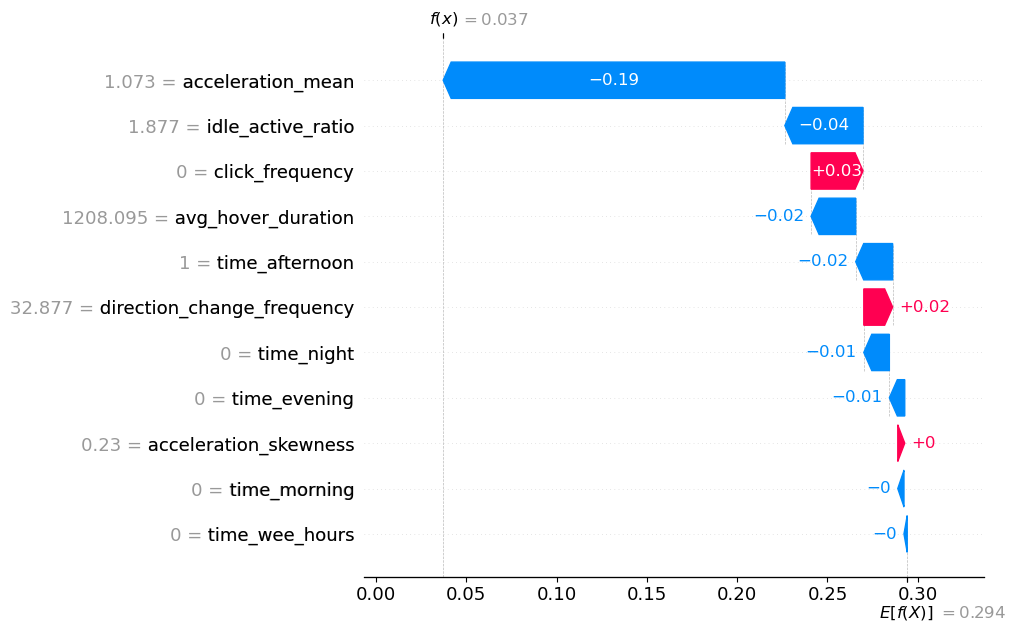

In [168]:
# Extract SHAP values for the second class (class 1)
shap_values_for_class_1 = shap_values[:, :, 1]  # Get SHAP values for class 1 (human)


# Visualize SHAP waterfall plot for the first test sample
shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_1[0], 
                                      base_values=shap_values.base_values[0], 
                                      data=X_test.iloc[0], 
                                      feature_names=feature_names),
                                      max_display=len(feature_names))



##### SHAP Values for the bot class

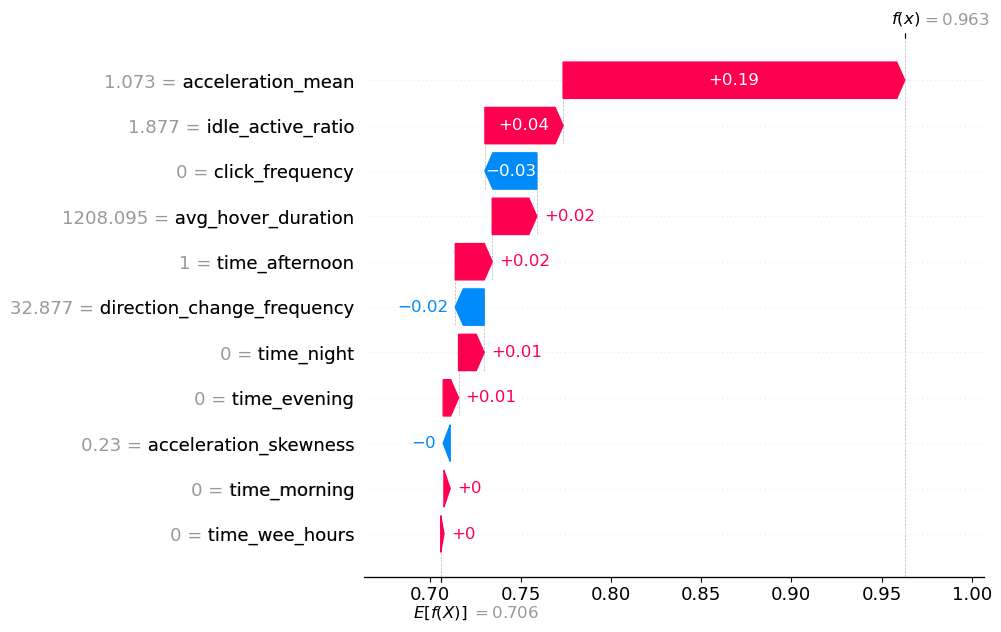

In [169]:
# Extract SHAP values for the first class (class 0)
shap_values_for_class_0 = shap_values[:, :, 0]  # Get SHAP values for class 0 (bot)


# Visualize SHAP waterfall plot for the first test sample
shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_0[0], 
                                      base_values=shap_values.base_values[0], 
                                      data=X_test.iloc[0], 
                                      feature_names=feature_names),
                                      max_display=len(feature_names))